In [ ]:
using Yao, YaoPlots
using LinearAlgebra, Statistics, Random, StatsBase, MAT, Printf
using Flux: batch, Flux
using Plots, PyPlot

# basic structure for block-encoding based QNNs

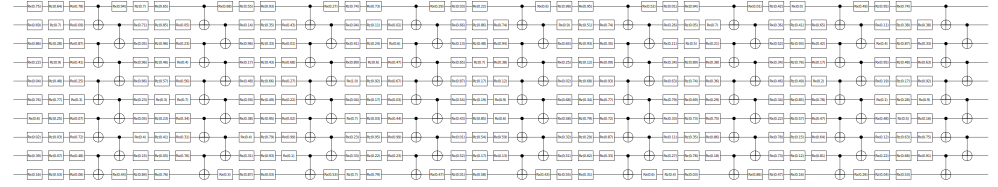

In [2]:
# import the FashionMNIST data
vars = matread("../dataset/FashionMNIST_1_2_wk.mat")
x_train = vars["x_train"]
y_train = vars["y_train"]
x_test = vars["x_test"]
y_test = vars["y_test"]
num_qubit = 10

# set the size of the training set and the test set
num_train = 500
num_test = 100
# set the scaling factor c = 2
c = 2
x_train = real(x_train[:,1:num_train])*c
y_train = y_train[1:num_train,:]
x_test = real(x_test[:,1:num_test])*c
y_test = y_test[1:num_test,:];

# define the QNN circuit, some functions have been defined before
include("../library/Layer.jl")
depth = 9
circuit = chain(chain(num_qubit, Params_Layer(num_qubit), 
        Ent_CX(num_qubit)) for _ in 1:depth)
# assign random initial parameters to the circuit
dispatch!(circuit, :random)
# record the initial parameters
ini_params = parameters(circuit);
YaoPlots.plot(circuit)

# data visualization

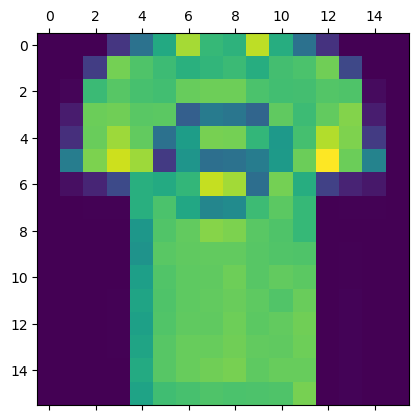

PyObject <matplotlib.image.AxesImage object at 0x7f2d5400c700>

In [3]:
i = 13
a = real(vars["x_train"][1:256,i])
c = reshape(a,(16,16))
matshow(c) # T-shirt

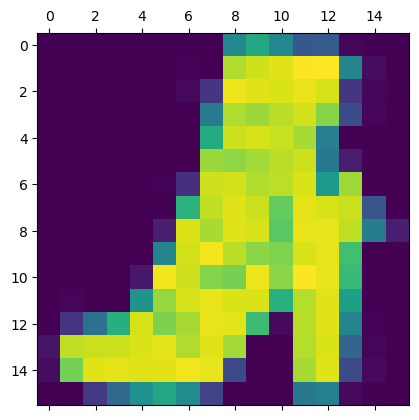

PyObject <matplotlib.image.AxesImage object at 0x7f2d53f07610>

In [4]:
i = 6
a = real(vars["x_train"][1:256,i])
c = reshape(a,(16,16))
matshow(c) # shoe

# data encoding

In [5]:
# we illustrate the idea of block-encoding based QNNs through a simple example
# the FashionMNIST dataset has been resized to be 256-dimensional
# we expand them to 270-dimensional by adding zeros at the end of the vectors
dim = 270
x_train_ = zeros(Float64,(dim,num_train))
x_train_[1:256,:] = x_train
x_train = x_train_
x_test_ = zeros(Float64,(dim,num_test))
x_test_[1:256,:] = x_test
x_test = x_test_

# the input data and the variational parameters are interleaved
# this strategy has been applied to [Ren et al, Experimental quantum adversarial
# learning with programmable superconducting qubits, arXiv:2204.01738]
# later we will numerically test the expressive power of this encoding strategy
train_cir = [chain(chain(num_qubit, Params_Layer(num_qubit), Ent_CX(num_qubit)) 
        for _ in 1:depth) for _ in 1:num_train]
test_cir = [chain(chain(num_qubit, Params_Layer(num_qubit), Ent_CX(num_qubit)) 
        for _ in 1:depth) for _ in 1:num_test];
for i in 1:num_train
    dispatch!(train_cir[i], x_train[:,i]+ini_params)
end
for i in 1:num_test
    dispatch!(test_cir[i], x_test[:,i]+ini_params)
end

# training

In [6]:
# hyper-parameters
batch_size = 50       # batch size
lr = 0.005            # learning rate
niters = 100          # number of iterations
optim = Flux.ADAM(lr) # Adam optimizer

# index of qubit that will be measured
pos_ = 5;       
op0 = put(num_qubit, pos_=>0.5*(I2+Z))
op1 = put(num_qubit, pos_=>0.5*(I2-Z));

# record the training history
loss_train_history = Float64[]
acc_train_history = Float64[]
loss_test_history = Float64[]
acc_test_history = Float64[];

include("../library/Loss_Accuracy.jl")
ini_theta = copy(ini_params);

In [7]:
for k in 1:niters
    # calculate the accuracy & loss for the training & test set
    train_acc, train_loss = acc_loss_rdm_cu(num_qubit,train_cir,y_train,num_train)
    test_acc, test_loss = acc_loss_rdm_cu(num_qubit,test_cir,y_test,num_test)
    push!(loss_train_history, train_loss)
    push!(loss_test_history, test_loss)
    push!(acc_train_history, train_acc)
    push!(acc_test_history, test_acc)
    if k % 10 == 0
        @printf("\nStep=%d, loss=%.3f, acc=%.3f, test_loss=%.3f,test_acc=%.3f\n",k,train_loss,train_acc,test_loss,test_acc)
    end
    
    # at each training epoch, randomly choose a batch of samples from the training set
    batch_index = randperm(size(x_train)[2])[1:batch_size]
    batch_cir = train_cir[batch_index]
    y_batch = y_train[batch_index,:]
    
    # this part is to add noise to test the robustness of the classifier
    # noise_batch_ = ε*rand(d, (batch_size,size(parameters(circuit))[1]))
    # for (i,j) in zip(batch_cir,1:batch_size)
    #     dispatch!(i,parameters(i)+noise_batch_[j,:])
    # end
    
    # for all samples in the batch, repeatly measure their qubits at position pos_ 
    # on the computational basis
    rdm = batch([density_matrix(focus!(zero_state(num_qubit) |> batch_cir[i], (pos_))).state for i in 1:batch_size])[:,:,1,:]
    q_ = zeros(batch_size,2);
    for i=1:batch_size
        q_[i,:] = diag(rdm[:,:,i]) |> real
    end
    
    # calculate the gradients w.r.t. the cross-entropy loss function
    Arr = Array{Float64}(zeros(batch_size,nparameters(batch_cir[1])))
    for i in 1:batch_size
        Arr[i,:] = expect'(op0, zero_state(num_qubit)=>batch_cir[i])[2]
    end
    C = [Arr, -Arr]
    grads = collect(mean([-sum([y_batch[i,j]*((1 ./ q_)[i,j])*batch(C)[i,:,j] for j in 1:2]) for i=1:batch_size]))
    
    # noise_grad = 0.1*ε*rand(d, size(parameters(circuit))) # added to the gradient when testing the robustness
    # update the parameters
    updates = Flux.Optimise.update!(optim, copy(ini_theta), grads);
    ini_theta = updates
    
    # if the noise is added above, cancel it at the end
    # recover the x
    #for (i,j) in zip(batch_cir,1:batch_size)
    #    dispatch!(i,parameters(i)-noise_batch_[j,:])
    #end
    
    # update the parameters
    for i in 1:num_train
        dispatch!(train_cir[i], x_train[:,i]+ini_theta)
    end
    for i in 1:num_test
        dispatch!(test_cir[i], x_test[:,i]+ini_theta)
    end
end


Step=10, loss=0.624, acc=0.978, test_loss=0.617,test_acc=1.000

Step=20, loss=0.571, acc=0.990, test_loss=0.561,test_acc=1.000

Step=30, loss=0.534, acc=0.990, test_loss=0.526,test_acc=1.000

Step=40, loss=0.497, acc=0.994, test_loss=0.487,test_acc=1.000

Step=50, loss=0.464, acc=0.996, test_loss=0.452,test_acc=1.000

Step=60, loss=0.432, acc=0.994, test_loss=0.419,test_acc=1.000

Step=70, loss=0.404, acc=0.990, test_loss=0.388,test_acc=1.000

Step=80, loss=0.383, acc=0.988, test_loss=0.367,test_acc=1.000

Step=90, loss=0.368, acc=0.990, test_loss=0.355,test_acc=1.000

Step=100, loss=0.354, acc=0.988, test_loss=0.337,test_acc=1.000


# visualization of the training

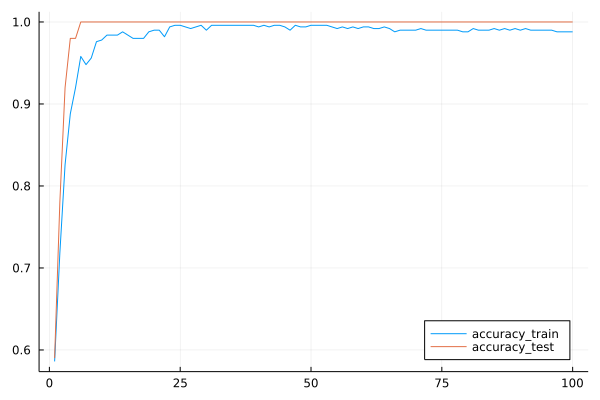

In [8]:
Plots.plot(acc_train_history,label="accuracy_train",legend = :bottomright)
Plots.plot!(acc_test_history,label="accuracy_test",legend = :bottomright)
# Plots.savefig("acc.pdf")

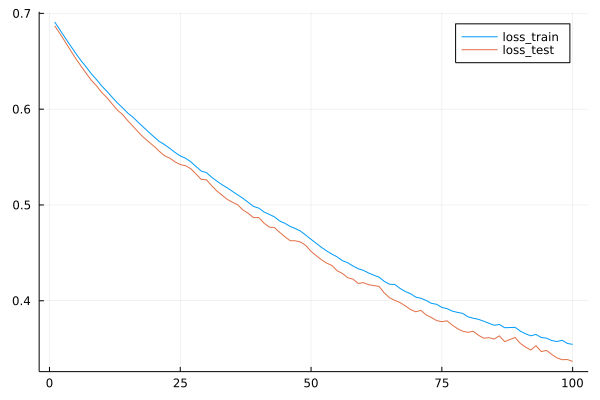

In [9]:
Plots.plot(loss_train_history,label="loss_train")
Plots.plot!(loss_test_history,label="loss_test")
# Plots.savefig("loss.pdf")

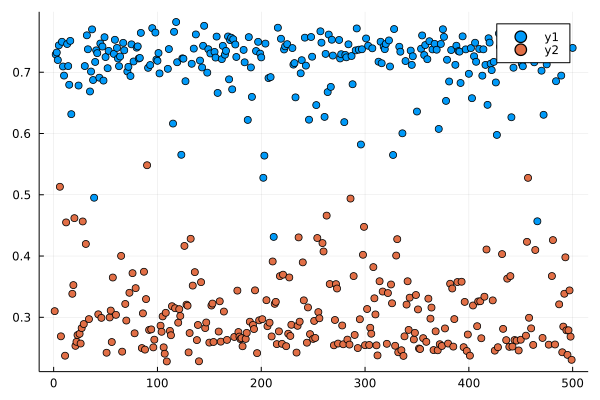

In [10]:
rdm = batch([density_matrix(focus!(zero_state(num_qubit) |> train_cir[i], (pos_))).state for i in 1:num_train])[:,:,1,:]
q_ = zeros(num_train,2);
for i=1:num_train
    q_[i,:] = diag(rdm[:,:,i]) |> real
end
class1x = Int64[]
class2x = Int64[]
class1y = Float64[]
class2y = Float64[]
for i in 1:num_train
    if y_train[i,1] == 1.0
        push!(class1x,i)
        push!(class1y,q_[i,1])
    else
        push!(class2x,i)
        push!(class2y,q_[i,1])
    end
end
# predicted value (expectation value)
# lower loss leads to larger separation between the two classes of data points
Plots.plot(class1x, class1y, seriestype = :scatter)
Plots.plot!(class2x, class2y, seriestype = :scatter)